# PBMC trimodal CD4 protein expression

Zoë Steier and Adam Gayoso

* Dataset: 10k PBMCs from 10x
* Example of trimodal protein expression: CD4 in PBMCs
* totalVI correctly separates foreground and background

## Imports and settings

In [1]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import sys

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from typing import Optional

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

sys.path.append("../utils/")

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=True

from scvi import set_seed
set_seed(0)

In [ ]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

## Load data and run totalVI

In [3]:
# Load anndata and make scVI dataset

anndataset_10k = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
global_high_var_genes = anndataset_10k.var.index[anndataset_10k.var["highly_variable"]]


dataset = AnnDatasetFromAnnData(ad = anndataset_10k[:, global_high_var_genes])
protein_data_10k = CellMeasurement(name="protein_expression", data=anndataset_10k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_10k.uns["protein_names"])
dataset.initialize_cell_measurement(protein_data_10k)

[2020-04-18 14:21:32,375] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-18 14:21:32,378] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-18 14:21:32,427] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-18 14:21:32,474] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells


In [4]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 6855 x 4000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_vars', 'protein_expression', 'labels', 'local_means'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

In [5]:
# Run totalVI model

model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_batch=dataset.n_batches,
)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
)
trainer.train(lr=lr, n_epochs=500)

[2020-04-18 14:26:55,327] INFO - scvi.inference.trainer | Reducing LR on epoch 318.
[2020-04-18 14:27:41,332] INFO - scvi.inference.trainer | Reducing LR on epoch 366.
[2020-04-18 14:29:25,970] INFO - scvi.inference.trainer | Reducing LR on epoch 471.



## Generate model outputs

In [6]:
full_posterior = trainer.create_posterior(model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior)

latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

N_SAMPLES = 50
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
py_mixing = np.mean(sigmoid(full_posterior.sequential().get_sample_mixing(n_samples=N_SAMPLES, give_mean=False)), axis=-1)
protein_pi = pd.DataFrame(data=py_mixing, columns=parsed_protein_names)

# Function below returns tuple (denoised_gene, denoised_pro) we concat here 
denoised_data = np.concatenate(full_posterior.sequential().get_normalized_denoised_expression(n_samples=N_SAMPLES, give_mean=True), axis=-1)

In [7]:
# Run UMAP
umap_dr = umap.UMAP(n_neighbors=15, random_state=42, min_dist=0.3).fit_transform(latent_mean)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html

## Plot CD4 trimodal expression and totalVI foreground probability

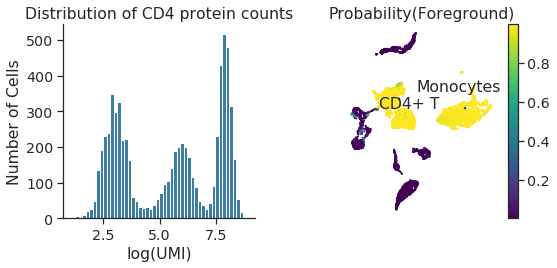

In [8]:
# Plot histogram of CD4 expression and totalVI foreground probability

gene = "CD4_TotalSeqB"
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(
    np.log(
        1 + dataset.protein_expression[:, np.where(dataset.protein_names == gene)[0]]
    ),
    bins=50,
)
sns.despine()
cax = ax[1].scatter(
    umap_dr[:, 0],
    umap_dr[:, 1],
    s=1,
    c=1 - py_mixing[:, np.where(dataset.protein_names == gene)[0]].ravel(),
    cmap="viridis",
)
ax[1].axis("off")
ax[0].set_title("Distribution of CD4 protein counts")
ax[0].set_ylabel("Number of Cells")
ax[0].set_xlabel("log(UMI)")
ax[1].set_title("Probability(Foreground)")
ax[1].annotate("CD4+ T", xy=(-7, 2.5))
# ax[1].annotate("CD8+ T", xy=(-13, -10))
ax[1].annotate("Monocytes", xy=(1, 6))
fig.colorbar(cax, ax=ax[1], orientation="vertical")
plt.tight_layout()
#plt.savefig("monocyte.pdf")

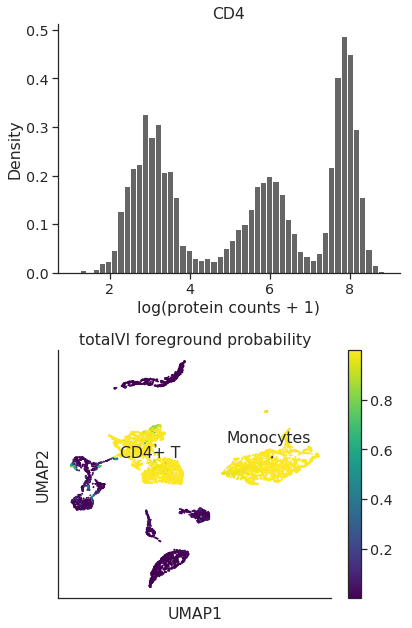

In [9]:
# Plot for saving

gene = "CD4_TotalSeqB"
fig, ax = plt.subplots(2, 1, figsize=(6, 9))
ax[0].hist(
    np.log(
        1 + dataset.protein_expression[:, np.where(dataset.protein_names == gene)[0]]
    ),
    bins=50,
    density = True,
    color = "0.4"
)
sns.despine()

cax = ax[1].scatter(
    umap_dr[:, 0],
    umap_dr[:, 1],
    s=1,
    c=1 - py_mixing[:, np.where(dataset.protein_names == gene)[0]].ravel(),
    cmap="viridis",
    rasterized = True,
)
#ax[1].axis("off")

ax[0].set_title("CD4")
ax[0].set_ylabel("Density")
ax[0].set_xlabel("log(protein counts + 1)")
ax[1].set_title("totalVI foreground probability")
ax[1].annotate("CD4+ T", xy=(-7, 2.5))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(axis='both', which='both', length=0)
ax[1].set_xlabel("UMAP1")
ax[1].set_ylabel("UMAP2")

# ax[1].annotate("CD8+ T", xy=(-13, -10))
ax[1].annotate("Monocytes", xy=(6, 5))
fig.colorbar(cax, ax=ax[1], orientation="vertical")
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/trimodal_PBMC.pdf", dpi=DPI, bbox_inches='tight')